In [32]:
import numpy as np 
import pandas as pd 
import gc
import utils as u
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import log_loss, f1_score, roc_curve, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
from plotnine import (ggplot, aes, geom_bar, theme, element_text, labs, ggtitle, scale_y_continuous, coord_flip, ggsave)

In [2]:
dir = 'data/'
out = 'mid_output/'
train_numeric = dir + 'train_numeric.csv'
train_cate = dir + 'train_categorical.csv'
test_cate = dir + 'test_categorical.csv'

# 

## Feature importance

In [3]:
# Due to a lot of features, selected 0-401 features, 401-801,..., 1601-2140 and repeated the following process
col = pd.read_csv(train_cate, nrows = 1).columns.to_list()
col = col[1:450] # 2140
col.append('Id')

In [ ]:
cate_train = u.load_data(train_cate, 2.5*10**5, 1.2*10**6, col)

In [5]:
col = list(set(cate_train.columns) - set(['Id']))
for i in col:
    le = LabelEncoder()
    le.fit(cate_train[i].fillna('NA'))

    cate_train[i] = le.transform(cate_train[i].fillna('NA'))


In [6]:
print(cate_train.shape)
response = pd.read_csv(train_numeric, usecols = ['Response'])
data = pd.concat([cate_train, response], axis = 1)
print(data.shape)

(1183747, 450)
(1183747, 451)


In [7]:
np.random.seed(10)
data = data.sample(frac = 1)

In [8]:
X = data.drop(['Id', 'Response'], axis = 1)
y = data['Response']
print(X.shape)
print(y.shape)

(1183747, 449)
(1183747,)


In [ ]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
scores = []
for tr_idx, va_idx in kf.split(X, y):
    tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
    tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

    dtrain = xgb.DMatrix(tr_x, label = tr_y)
    dvalid = xgb.DMatrix(va_x, label = va_y)

    num_round = 100
    params = {'colsample_bytree':0.4, 
              'eta':0.1,
              'max_depth': 5,
              'subsample': 0.8,
              'eval_metric': 'logloss',
              'objective': 'binary:logistic',
              'random_state': 71,
              'silent': 0
            }

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    model = xgb.train(params, dtrain, num_round, evals = watchlist, early_stopping_rounds = 10)
    va_pred = model.predict(dvalid)
    score = log_loss(va_y, va_pred)
    print('logss value: {}'.format(score))
    scores.append(score)
    del va_pred, score
    gc.collect()

print('avg_logloss:', np.mean(scores))


In [14]:
# model.save_model("cate_xgb_model.json")

In [67]:
# model = xgb.Booster()
# model.load_model("cate_xgb_model-1.json")
fscore = model.get_score(importance_type = 'total_gain')

keys = list(fscore.keys())
values = list(fscore.values())
feat_imp = pd.DataFrame({'feature': keys, 'scores': values}, index=keys).sort_values(by = "scores", ascending=True)
feat_imp['feature'] = pd.Categorical(
feat_imp.feature, categories=pd.unique(feat_imp.feature))
feat_imp['score'] = feat_imp['scores'].transform(lambda x: (x/float(x.sum())*100))
feat_imp
  

,feature,scores,score
L0_S2_F39,L0_S2_F39,0.862793,0.004708
L0_S9_F179,L0_S9_F179,1.152344,0.006288
L0_S9_F159,L0_S9_F159,1.180664,0.006443
L0_S9_F184,L0_S9_F184,1.526978,0.008333
L3_S44_F4102,L3_S44_F4102,1.606696,0.008768
...,...,...,...
L1_S24_F1510,L1_S24_F1510,193.665192,1.056805
L1_S24_F1523,L1_S24_F1523,234.780960,1.281169
T1,T1,403.081879,2.199564
L3_S32_F3851,L3_S32_F3851,5125.208008,27.967581


In [75]:
# select top k importance features
k = 20
features = list(feat_imp.iloc[-k:, 0])
features.append('Id')
cate_train = pd.read_csv(train_cate, usecols = features)
cate_test = pd.read_csv(test_cate, usecols = features)

c:\py_venv\tutorial-venv\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (807,809,811,842,984,1587,1985,1987) have mixed types.Specify dtype option on import or set low_memory=False.
c:\py_venv\tutorial-venv\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (807,809,811,842,984,1985,1987) have mixed types.Specify dtype option on import or set low_memory=False.


In [76]:
col = list(set(cate_train.columns) - set(['Id']))
for i in col:
    le = LabelEncoder()
    le.fit(cate_train[i].fillna('NA'))

    cate_test[i] = cate_test[i].fillna('NA')
    cate_test[i] = cate_test[i].map(lambda s: -1 if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, - 1)

    cate_train[i] = le.transform(cate_train[i].fillna('NA'))
    cate_test[i] = le.transform(cate_test[i])


In [15]:
gc.collect()
cate_train.to_csv(out + 'cate_train_xgb.csv')
cate_test.to_csv(out + 'cate_test_xgb.csv')

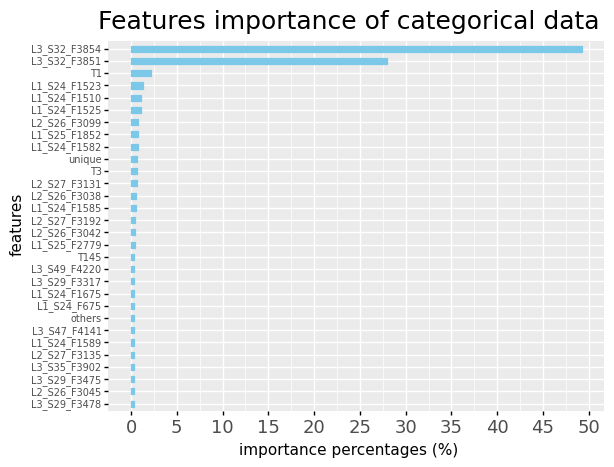

<ggplot: (-9223371870594306288)>

In [69]:
g = (
    ggplot(feat_imp.iloc[-30:, :])
    + geom_bar(aes(x = 'feature', y = 'score'), stat = "identity", color='#7cc8e9', fill='#7cc8e9', width = 0.5)
    + theme(axis_text_x = element_text(angle = 0, size = 13),
            axis_text_y=element_text(size=7),
            plot_title=element_text(size=18))
    + scale_y_continuous(breaks = range(0, 100, 5))
    + coord_flip()
    + labs(x = 'features',y = 'importance percentages (%)')
    + ggtitle('Features importance of categorical data')
)
# ggsave(file="Features importance of numeric data.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g